In [6]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from Classifications import Classifications

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

In [8]:
seed = 42
rng = np.random.default_rng(seed=seed)
classifications = Classifications()

In [9]:
import glob
data_csvs = glob.glob("../csvs/*.csv")

df = pd.concat([pd.read_csv(data_csv) for data_csv in data_csvs], ignore_index=True)

# Magnitudes
df["|a|"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
df["|g|"] = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)

plot_width = len(df) // 60
num_xticks = len(df) // 80
x_ticks = np.linspace(df["ms"].min(), df["ms"].max(), num=num_xticks)

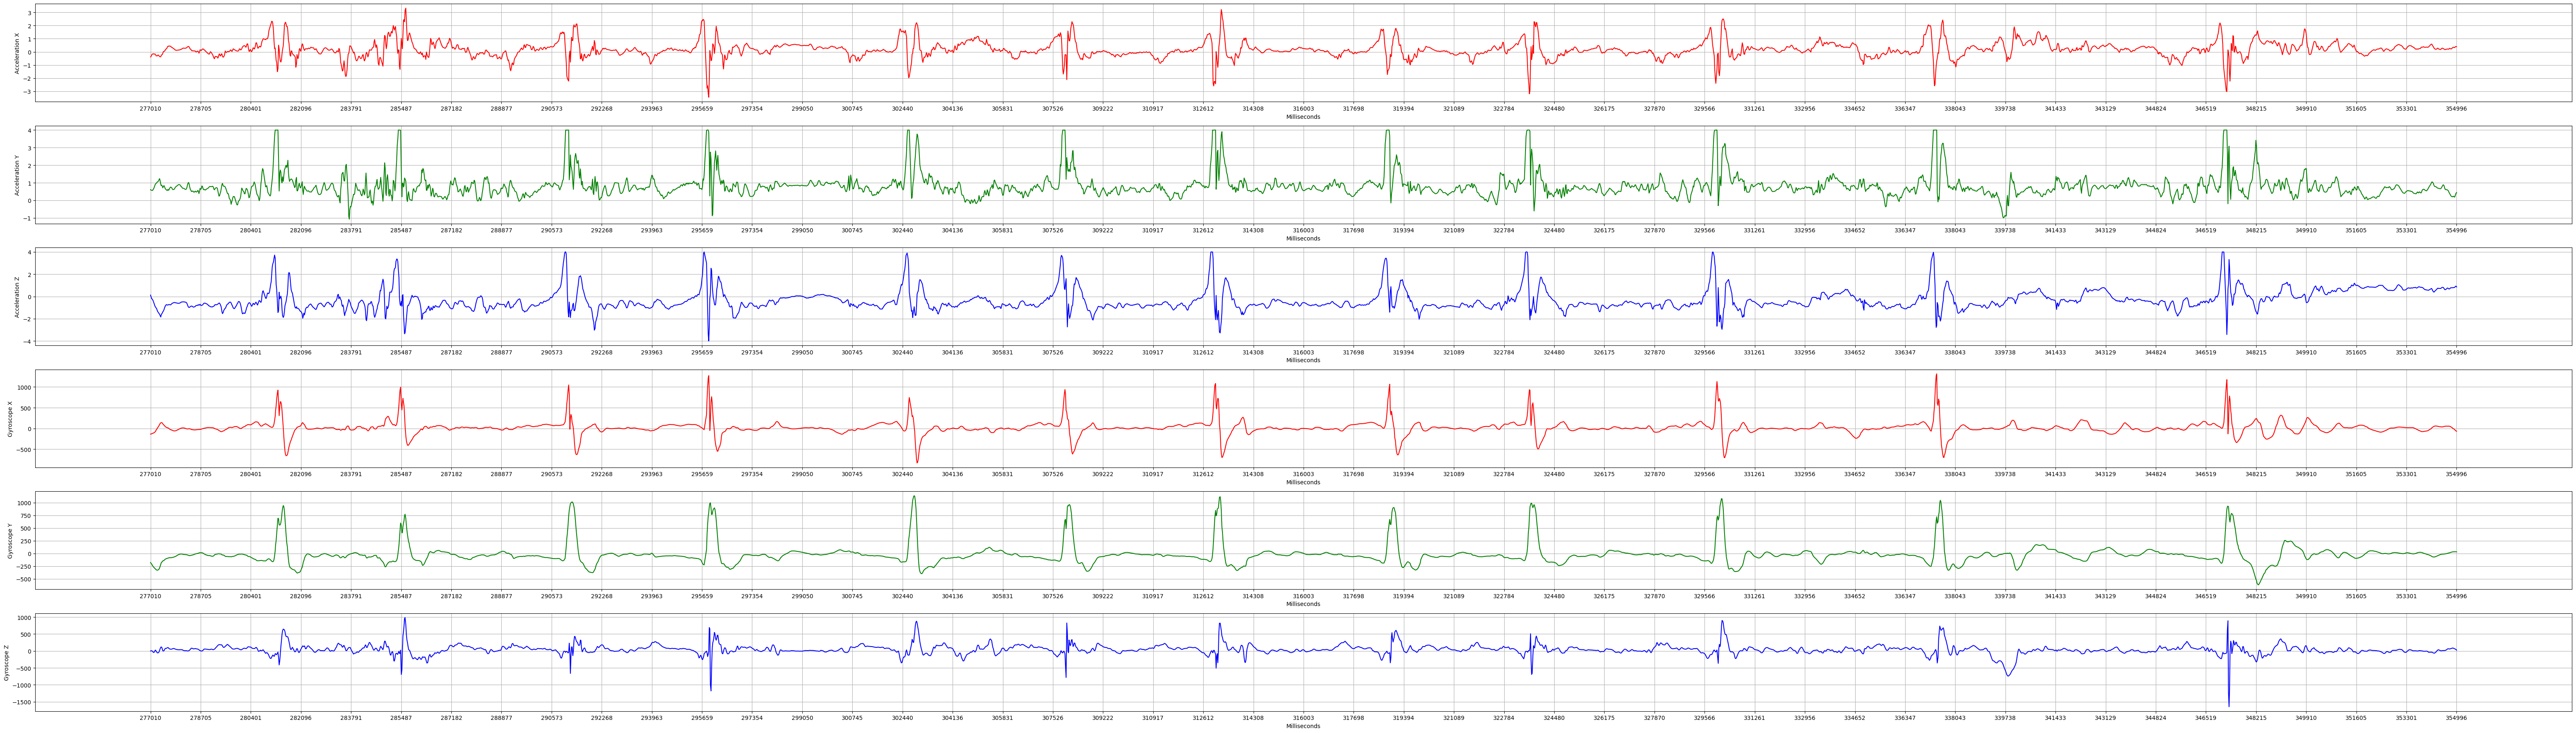

In [5]:
# Raw data plot
plots = (
    { "label": "ax", "title": "Acceleration X", "color": "r" },
    { "label": "ay", "title": "Acceleration Y", "color": "g" },
    { "label": "az", "title": "Acceleration Z", "color": "b" },
    { "label": "gx", "title": "Gyroscope X", "color": "r" },
    { "label": "gy", "title": "Gyroscope Y", "color": "g" },
    { "label": "gz", "title": "Gyroscope Z", "color": "b" },
)

fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))
for ax, plot in zip(axes, plots):
    ax.plot(df["ms"], df[plot["label"]], label=plot["title"], color=plot["color"])
    ax.set_xlabel("Milliseconds")
    ax.set_ylabel(plot["title"])
    ax.set_xticks(x_ticks)
    ax.ticklabel_format(style='plain')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Chunked Online Z-Score Normalization of Data (as would happen on Arduino)
sensors = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
normalized_sensors = [f"{col}'" for col in sensors]
df[normalized_sensors] = np.nan

scaler = StandardScaler()
chunk_size = classifications.num_sensor_data_entries
for i in range(0, len(df), chunk_size):
    j = i + chunk_size - 1
    chunk = df.loc[i:j, sensors]
    normalized_chunk = scaler.partial_fit(chunk[sensors]).transform(chunk[sensors])
    df.loc[i:j, normalized_sensors] = normalized_chunk

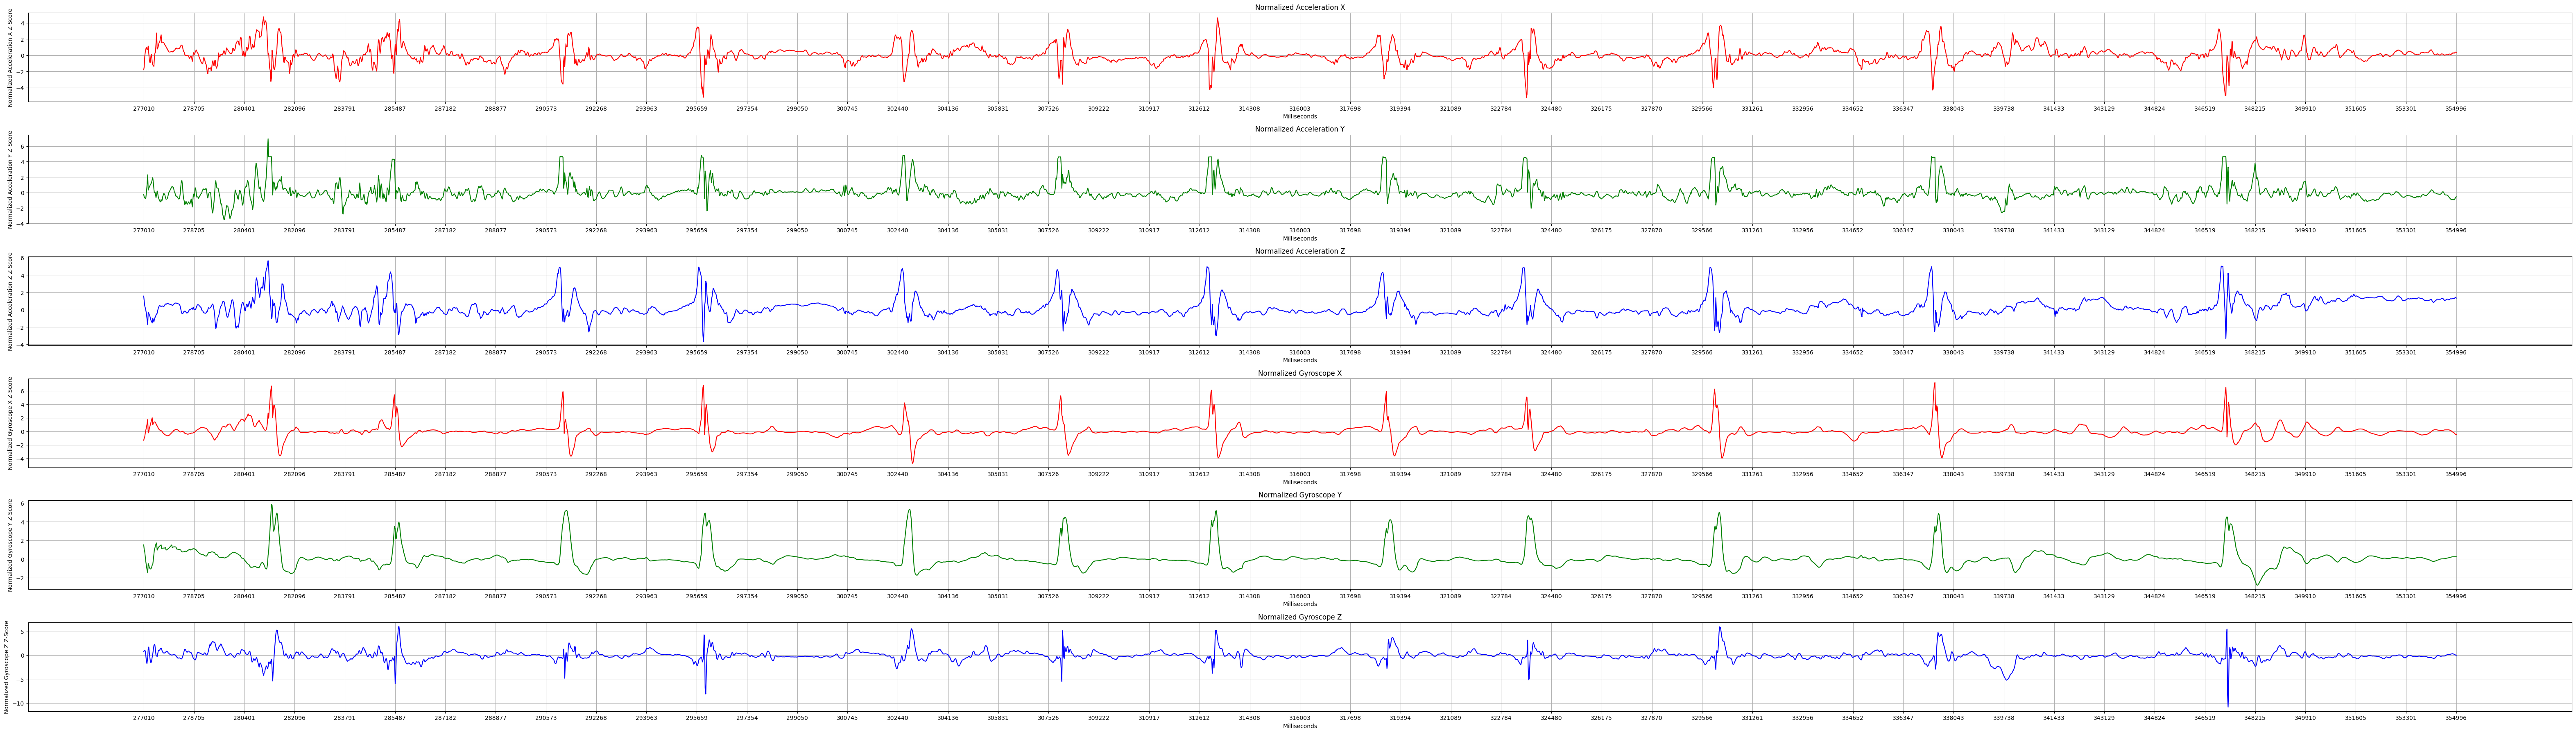

In [7]:
# Normalized data plot
plots = (
    { "label": "ax'", "title": "Normalized Acceleration X", "color": "r" },
    { "label": "ay'", "title": "Normalized Acceleration Y", "color": "g" },
    { "label": "az'", "title": "Normalized Acceleration Z", "color": "b" },
    { "label": "gx'", "title": "Normalized Gyroscope X", "color": "r" },
    { "label": "gy'", "title": "Normalized Gyroscope Y", "color": "g" },
    { "label": "gz'", "title": "Normalized Gyroscope Z", "color": "b" },
)

fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))

for ax, plot in zip(axes, plots):
    label = plot["label"]
    ax.plot(df["ms"], df[label], color=plot["color"], linestyle='-')
    ax.set_xlabel("Milliseconds")
    ax.set_ylabel(f"{plot['title']} Z-Score")
    ax.set_title(plot["title"])
    ax.set_xticks(x_ticks)
    ax.ticklabel_format(style='plain')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Acceleration Squared (will be used on Arduino as threshold for shot detection)
df["a^2"] = np.sum(df[["ax", "ay", "az"]].values**2, axis=1)

# Peak detection
peaks, _ = find_peaks(
    df["a^2"],
    height=classifications.squared_acceleration_threshold,
    distance=classifications.num_steps,
)

counts = (
    df.loc[peaks].groupby(["spin", "side", "stroke"], sort=False)
      .size()
      .reset_index(name="count")
)
print(counts.to_string(index=False))

   spin     side       stroke  count
  Slice Forehand Groundstroke     77
   Flat Forehand     Overhead     46
   Flat Backhand     Overhead     10
  Slice Forehand        Serve     38
   Flat Forehand        Serve     53
Topspin Forehand        Serve     58
  Slice Backhand Groundstroke     55
   Flat Backhand Groundstroke     44
Topspin Backhand Groundstroke     36
  Slice Forehand       Volley     70
  Slice Backhand       Volley     89
  Slice Forehand     Overhead     36
Topspin Forehand Groundstroke     19
   Flat Forehand Groundstroke     37


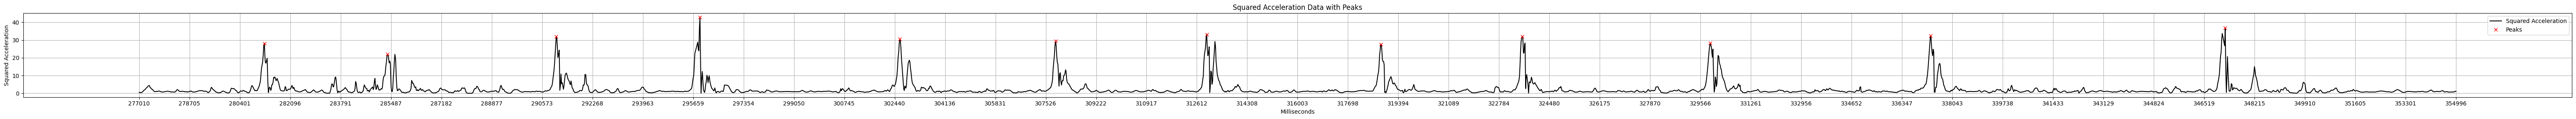

In [9]:
# Peaks plot
fig, ax = plt.subplots(figsize=(plot_width, 3))
ax.plot(df["ms"], df["a^2"], label="Squared Acceleration", color="k")
ax.plot(df.loc[peaks, "ms"], df.loc[peaks, "a^2"], "rx", label="Peaks")
ax.set_title("Squared Acceleration Data with Peaks")
ax.set_xlabel("Milliseconds")
ax.set_ylabel("Squared Acceleration")
ax.set_xticks(x_ticks)
ax.ticklabel_format(style='plain')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

Rotated coordinate vectors:
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]

Euler rotations:
[180.   0.   0.]
64


Rotated coordinate vectors:
[[-0.2544484   0.29665039  0.92046432]
 [-0.7800519   0.49964543 -0.37666096]
 [-0.57164241 -0.81385072  0.10426873]]

Euler rotations:
[-74.52664384 -66.99405642 130.62095523]
64


Rotated coordinate vectors:
[[ 0.39058623  0.88996769 -0.23537187]
 [ 0.91874984 -0.36080416  0.16037173]
 [ 0.05780251 -0.27888685 -0.9585828 ]]

Euler rotations:
[170.50232691  13.61354399  66.3044413 ]
64


Rotated coordinate vectors:
[[-0.42529368  0.66308846  0.61598618]
 [-0.63587041  0.26540846 -0.72472559]
 [-0.64404512 -0.69990859  0.30876179]]

Euler rotations:
[-66.92407547 -38.02361323 122.6754228 ]
64


Rotated coordinate vectors:
[[-0.33445358 -0.2932773   0.89561667]
 [ 0.42667004  0.80024471  0.42137997]
 [-0.84029369  0.52306484 -0.14251207]]

Euler rota

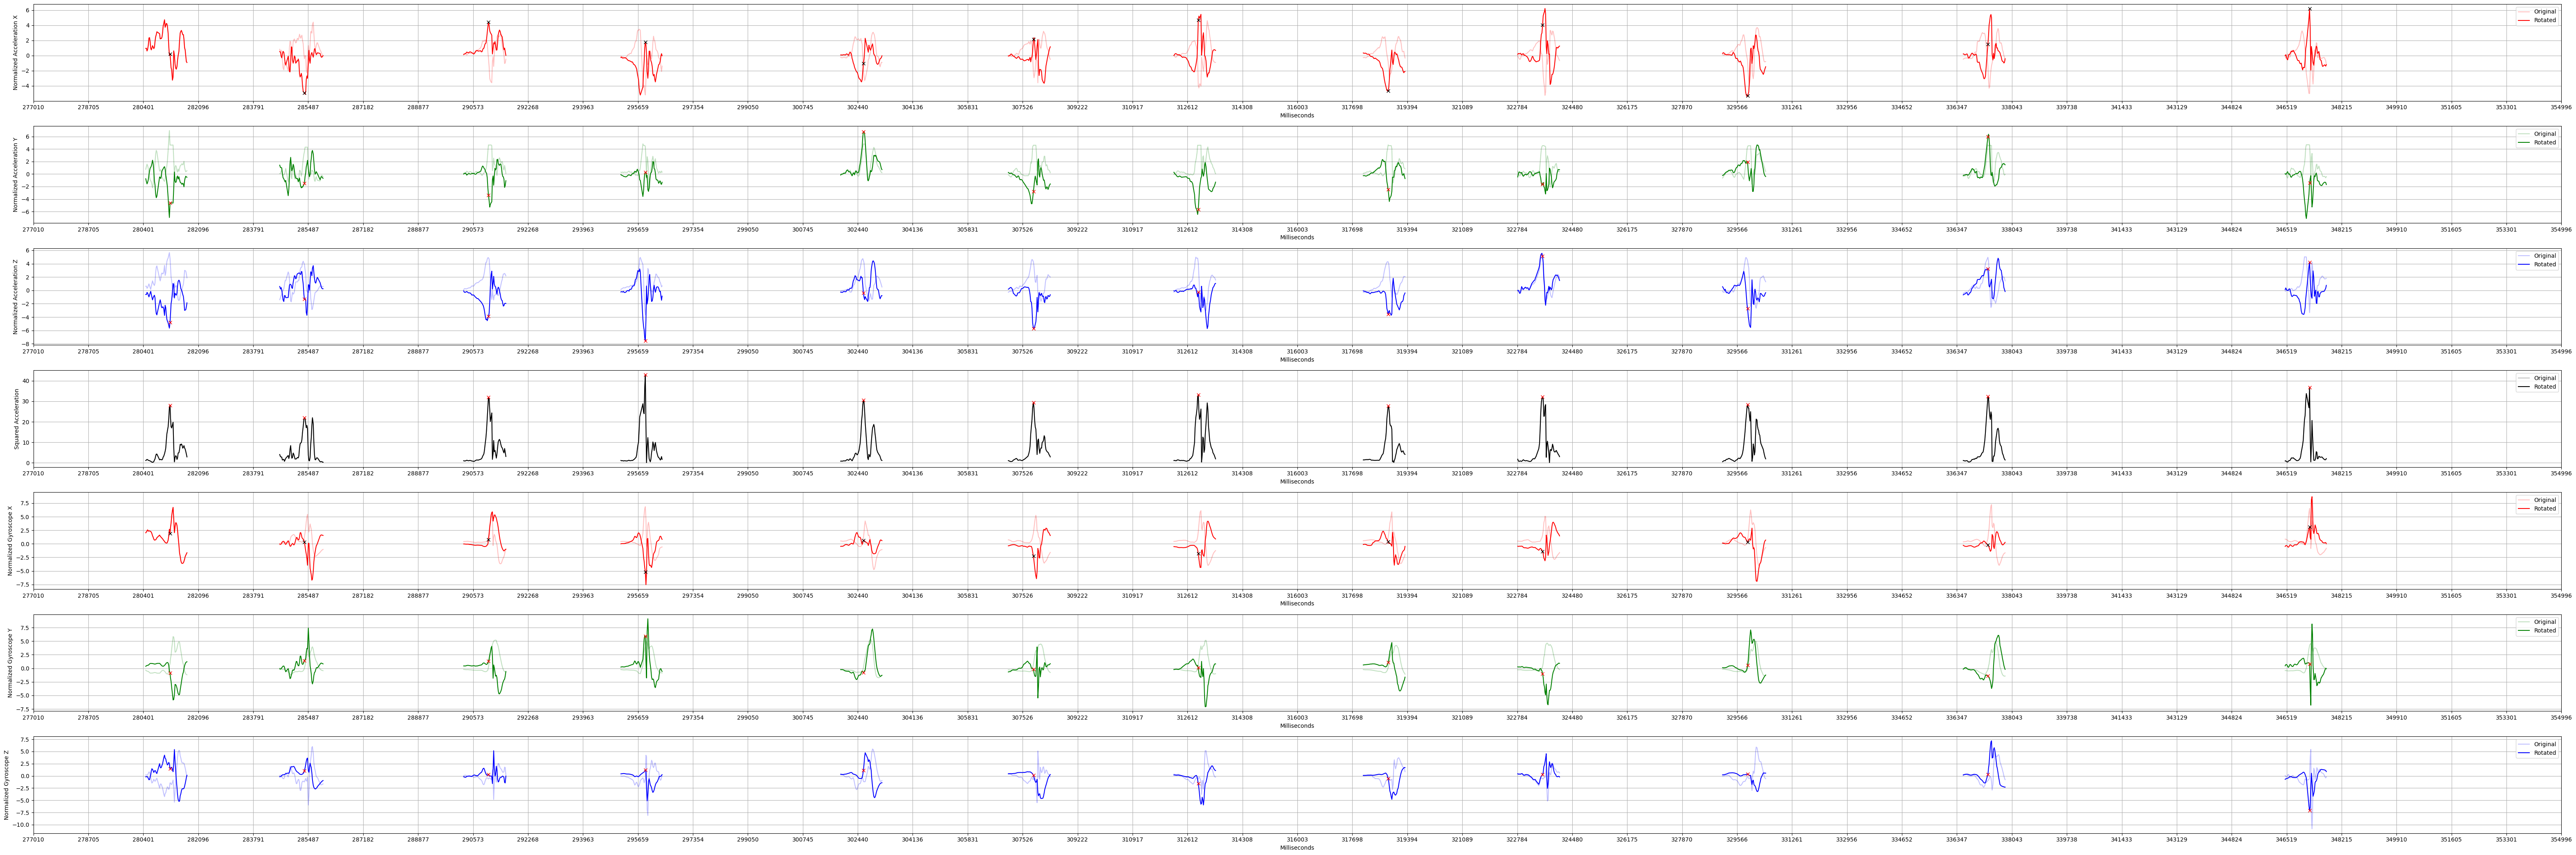

In [10]:
plots = (
    { "label": "ax'", "title": "Normalized Acceleration X", "color": "r", "marker": "kx" },
    { "label": "ay'", "title": "Normalized Acceleration Y", "color": "g", "marker": "rx" },
    { "label": "az'", "title": "Normalized Acceleration Z", "color": "b", "marker": "rx" },
    { "label": "a^2", "title": "Squared Acceleration", "color": "k", "marker": "rx" },
    { "label": "gx'", "title": "Normalized Gyroscope X", "color": "r", "marker": "kx" },
    { "label": "gy'", "title": "Normalized Gyroscope Y", "color": "g", "marker": "rx" },
    { "label": "gz'", "title": "Normalized Gyroscope Z", "color": "b", "marker": "rx" },
)

labels = [d["label"] for d in plots]

# Plotting just the normalized detected shot data
fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))

first = True
for peak in peaks:
    # Random rotation for generalization
    if first:
        random_rotation = R.from_euler(seq="x", angles=180, degrees=True)
    else:
        random_rotation = R.random(rng=rng)
    rotated_vectors = random_rotation.apply(np.identity(3))
    if not first:
        print("\n")
    print(f"Rotated coordinate vectors:\n{rotated_vectors}\n")
    print(f"Euler rotations:\n{random_rotation.as_euler('xyz', degrees=True)}")

    start_idx = max(0, peak - classifications.steps_before_peak)
    end_idx = peak + classifications.steps_after_peak

    shot_data = df.loc[start_idx:end_idx].reset_index(drop=True)
    rotated_shot_data = shot_data.copy()
    print(len(shot_data))

    rotated_shot_data[["ax'", "ay'", "az'"]] = random_rotation.apply(shot_data[["ax'", "ay'", "az'"]].to_numpy())
    rotated_shot_data[["gx'", "gy'", "gz'"]] = random_rotation.apply(shot_data[["gx'", "gy'", "gz'"]].to_numpy())

    for ax, plot in zip(axes, plots):
        ax.plot(shot_data["ms"], shot_data[plot["label"]], label="Original", color=plot["color"], alpha=0.25)
        ax.plot(rotated_shot_data["ms"], rotated_shot_data[plot["label"]], label="Rotated", color=plot["color"])
        ax.plot(rotated_shot_data.loc[classifications.steps_before_peak, "ms"], rotated_shot_data.loc[classifications.steps_before_peak, plot["label"]], plot["marker"])

        ax.set_xlabel("Milliseconds")
        ax.set_ylabel(plot["title"])

        ax.set_xticks(x_ticks)
        ax.ticklabel_format(style='plain')

        if first:
            ax.legend()
        ax.grid(True)
    first = False

plt.tight_layout()
plt.show()